In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Set additional options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
raw_data = pd.read_csv(r"C:\Users\e014694\OneDrive - Telstra\Documents\Git\Fraudulent_payments\Data\Base.csv")

raw_data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.90,0.17,-1,88,50,0.02,-1.33,AA,769,10650.77,3134.32,3863.65,1,6,CA,185,0,BA,1,0,24,0,500.00,0,INTERNET,3.89,windows,0,1,0,7
1,1,0.90,0.30,-1,144,50,0.01,-0.82,AB,366,534.05,2670.92,3124.30,718,3,CA,259,1,BA,0,0,15,0,1500.00,0,INTERNET,31.80,windows,0,1,0,7
2,1,0.90,0.04,-1,132,40,3.11,-0.76,AC,870,4048.53,2893.62,3159.59,1,14,CB,177,1,BA,0,1,-1,0,200.00,0,INTERNET,4.73,other,0,1,0,7
3,1,0.90,0.16,-1,22,50,0.02,-1.21,AB,810,3457.06,4054.91,3022.26,1921,6,CA,110,1,BA,0,1,31,1,200.00,0,INTERNET,2.05,linux,0,1,0,7
4,1,0.90,0.60,-1,218,50,0.00,-0.77,AB,890,5020.34,2728.24,3087.67,1990,2,CA,295,1,BA,1,0,31,0,1500.00,0,INTERNET,3.78,macintosh,1,1,0,7


In [4]:
fraud_counts = pd.DataFrame(raw_data['fraud_bool'].value_counts()).reset_index()
fraud_counts

,fraud_bool,count
0,0,988971
1,1,11029


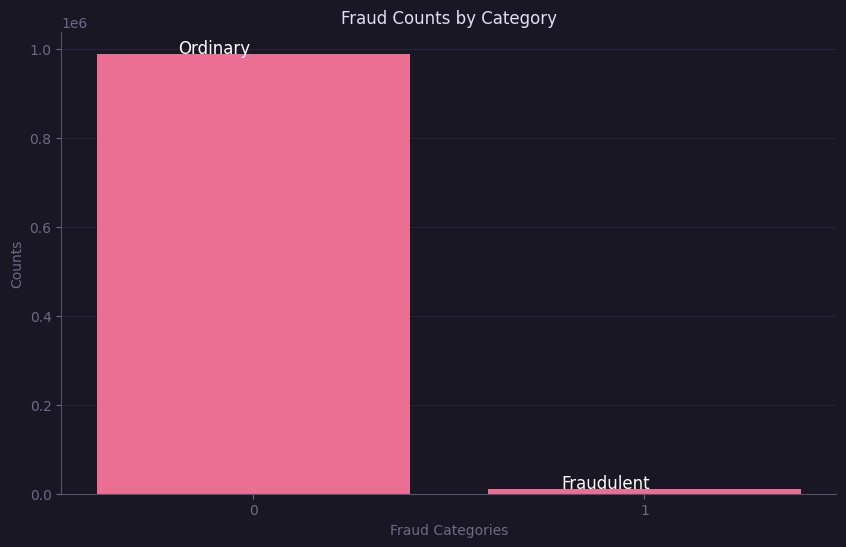

In [5]:
plt.style.use('rose-pine')

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(fraud_counts['fraud_bool'], fraud_counts['count'])
plt.xlabel('Fraud Categories')
plt.ylabel('Counts')
plt.title('Fraud Counts by Category')

labels = ['Ordinary', 'Fraudulent']

# Add custom labels to the bars
for bar, label in zip(bars, labels):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, label, ha='center', color='white', fontsize=12)

# Customize the x-axis tick labels
plt.xticks([0, 1], ['0', '1'])

# Show the chart
plt.show()

### 3. Data Preparation

First we need to investigate the data to observe the suitablitlty for modelling. The aim is to prepare the data to aide the model

[improve...]

In [6]:
raw_data.head(5).T

,0,1,2,3,4
fraud_bool,1,1,1,1,1
income,0.90,0.90,0.90,0.90,0.90
name_email_similarity,0.17,0.30,0.04,0.16,0.60
prev_address_months_count,-1,-1,-1,-1,-1
current_address_months_count,88,144,132,22,218
customer_age,50,50,40,50,50
days_since_request,0.02,0.01,3.11,0.02,0.00
intended_balcon_amount,-1.33,-0.82,-0.76,-1.21,-0.77
payment_type,AA,AB,AC,AB,AB
zip_count_4w,769,366,870,810,890


In [7]:
raw_data.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
mean,0.01,0.56,0.49,16.72,86.59,33.69,1.03,8.66,1572.69,5665.30,4769.78,4856.32,184.36,9.50,130.99,0.53,0.42,0.89,10.84,0.22,515.85,0.03,7.54,0.58,1.02,0.00,3.29
std,0.10,0.29,0.29,44.05,88.41,12.03,5.38,20.24,1005.37,3009.38,1479.21,919.84,459.63,5.03,69.68,0.50,0.49,0.31,12.12,0.42,487.56,0.16,8.03,0.49,0.18,0.00,2.21
min,0.00,0.10,0.00,-1.00,-1.00,10.00,0.00,-15.53,1.00,-170.60,1300.31,2825.75,0.00,0.00,-170.00,0.00,0.00,0.00,-1.00,0.00,190.00,0.00,-1.00,0.00,-1.00,0.00,0.00
25%,0.00,0.30,0.23,-1.00,19.00,20.00,0.01,-1.18,894.00,3436.37,3593.18,4268.37,1.00,6.00,83.00,0.00,0.00,1.00,-1.00,0.00,200.00,0.00,3.10,0.00,1.00,0.00,1.00
50%,0.00,0.60,0.49,-1.00,52.00,30.00,0.02,-0.83,1263.00,5319.77,4749.92,4913.44,9.00,9.00,122.00,1.00,0.00,1.00,5.00,0.00,200.00,0.00,5.11,1.00,1.00,0.00,3.00
75%,0.00,0.80,0.76,12.00,130.00,40.00,0.03,4.98,1944.00,7680.72,5752.57,5488.08,25.00,13.00,178.00,1.00,1.00,1.00,25.00,0.00,500.00,0.00,8.87,1.00,1.00,0.00,5.00
max,1.00,0.90,1.00,383.00,428.00,90.00,78.46,112.96,6700.00,16715.57,9506.90,6994.76,2385.00,39.00,389.00,1.00,1.00,1.00,32.00,1.00,2100.00,1.00,85.90,1.00,2.00,0.00,7.00


There are a number of categorical features within the data set. As such, need to apply one hot encoding.

One-hot encoding is a technique used in data preprocessing and feature engineering, primarily in the context of machine learning and data analysis. It's employed to represent categorical variables as binary vectors (0s and 1s). Each category or label within a categorical variable is transformed into a binary feature, where each feature corresponds to one category and is either "on" (1) or "off" (0) based on whether the original data point falls into that category.

In [8]:
raw_data = pd.get_dummies(raw_data)

### 3.2 Data Skewness

Skewwnes: Skewness is the degree of asymmetry observed in a distribution. Distributions can exhibit right (positive) skewness or left (negative) skewness to varying degrees. A normal distribution (bell curve) exhibits zero skewness.

Skewed data can have an adverse impact when modelling as the data points are not distruted through the range in an even manor. [improve]

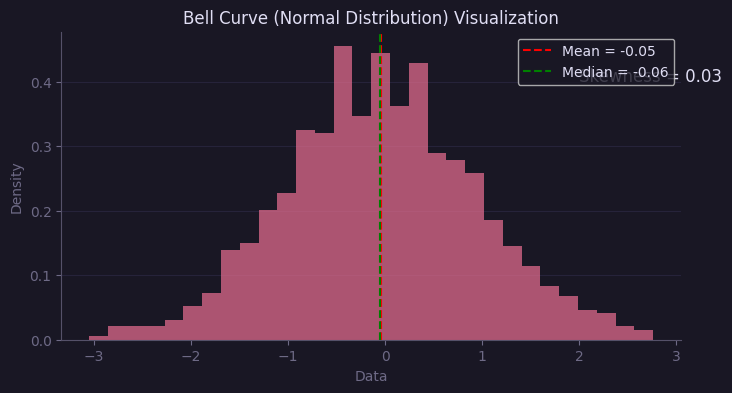

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a sample dataset with a bell curve (normal distribution)
np.random.seed(0)
mean = 0  # Mean of the normal distribution
std_dev = 1  # Standard deviation of the normal distribution
data = np.random.normal(mean, std_dev, size=1000)  # Example dataset with a bell curve

# Create a DataFrame
df = pd.DataFrame({'Data': data})

# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(df['Data'], bins=30, density=True, alpha=0.7)
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = df['Data'].skew()
plt.axvline(x=df['Data'].mean(), color='red', linestyle='--', label=f'Mean = {df["Data"].mean():.2f}')
plt.axvline(x=df['Data'].median(), color='green', linestyle='--', label=f'Median = {df["Data"].median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()


This is an example of what a normally distributed data set could look like. Where the mean and median are in the middle of the distribution.

In [10]:
numeric_cols =  [cname for cname in raw_data.loc[:, :'month'].columns if
                  pd.to_numeric(raw_data[cname], errors='coerce').notna().all() and
                  raw_data[cname].min() >= 0 and
                  raw_data[cname].dtype in ['int64', 'float64']]

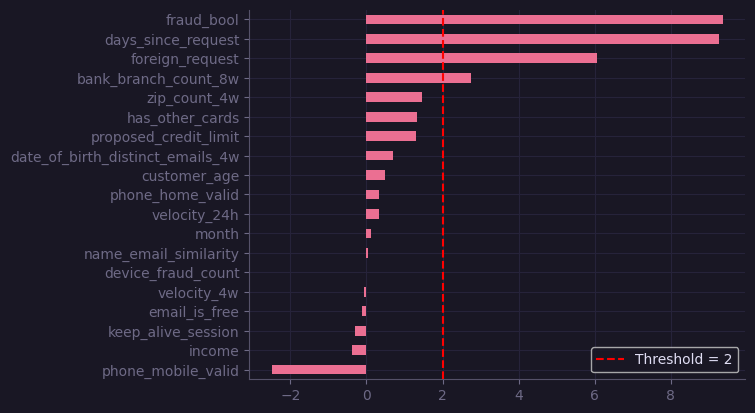

In [11]:
raw_data[numeric_cols].skew(numeric_only=True).sort_values().plot(kind = 'barh')

plt.axvline(x=2, color='red', linestyle='--', label='Threshold = 2')
plt.legend()

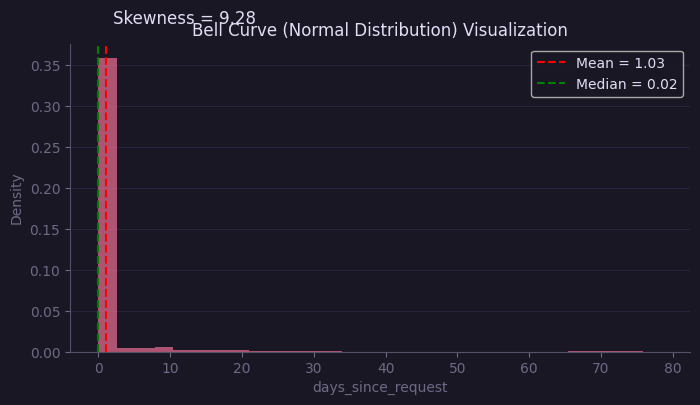

In [12]:
# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(raw_data['days_since_request'], bins=30, density=True, alpha=0.7)
plt.xlabel('days_since_request')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = raw_data['days_since_request'].skew()
plt.axvline(x=raw_data['days_since_request'].mean(), color='red', linestyle='--', label=f'Mean = {raw_data["days_since_request"].mean():.2f}')
plt.axvline(x=raw_data['days_since_request'].median(), color='green', linestyle='--', label=f'Median = {raw_data["days_since_request"].median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()

Visualising the 'days_since_request' field shows how non-normal distribution may look. To remedy this a log function can be used to improve the distrubtion for our purposes.

In [13]:
test_field = np.log10(raw_data['days_since_request'])

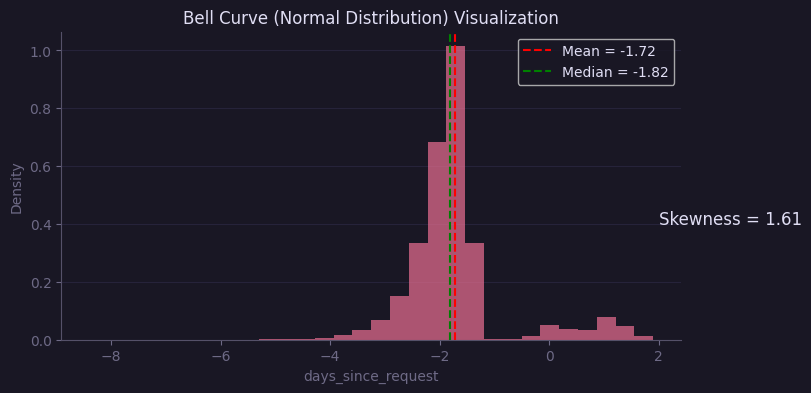

In [14]:
# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(test_field, bins=30, density=True, alpha=0.7)
plt.xlabel('days_since_request')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = test_field.skew()
plt.axvline(x=test_field.mean(), color='red', linestyle='--', label=f'Mean = {test_field.mean():.2f}')
plt.axvline(x=test_field.median(), color='green', linestyle='--', label=f'Median = {test_field.median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()

As can be seen in the graph, applying a log10 function to the field has improved the skew of the data. Reducing the skew score from 9.28 to 1.61, roughly a 9x improvement in skew. This will support the model in assessing the impact the variation of these fields have on the output.

In [15]:
cleaning_data = raw_data

In [16]:
# Apply a log transformation to the features that were over the threshold
cleaning_data['log_days_since_request'] = np.log10(cleaning_data['days_since_request'])
cleaning_data['zip_count_4w'] = np.log10(cleaning_data['zip_count_4w'])

#cleaning_data['bank_branch_count_8w'] = np.log10(cleaning_data['bank_branch_count_8w'])   this gives inf vaules, either ignore or find the best way to sub

In [17]:
cleaning_data.drop(columns = ['days_since_request','zip_count_4w'], inplace = True)

## 4 Feature Selection

When features within a dataset correlate too much, often indicating some causal-relationship, it can negaitivley impact the model and lead to overfitting of the data. As such it's necessary to check for these instances and remove additional features that may be redundant.

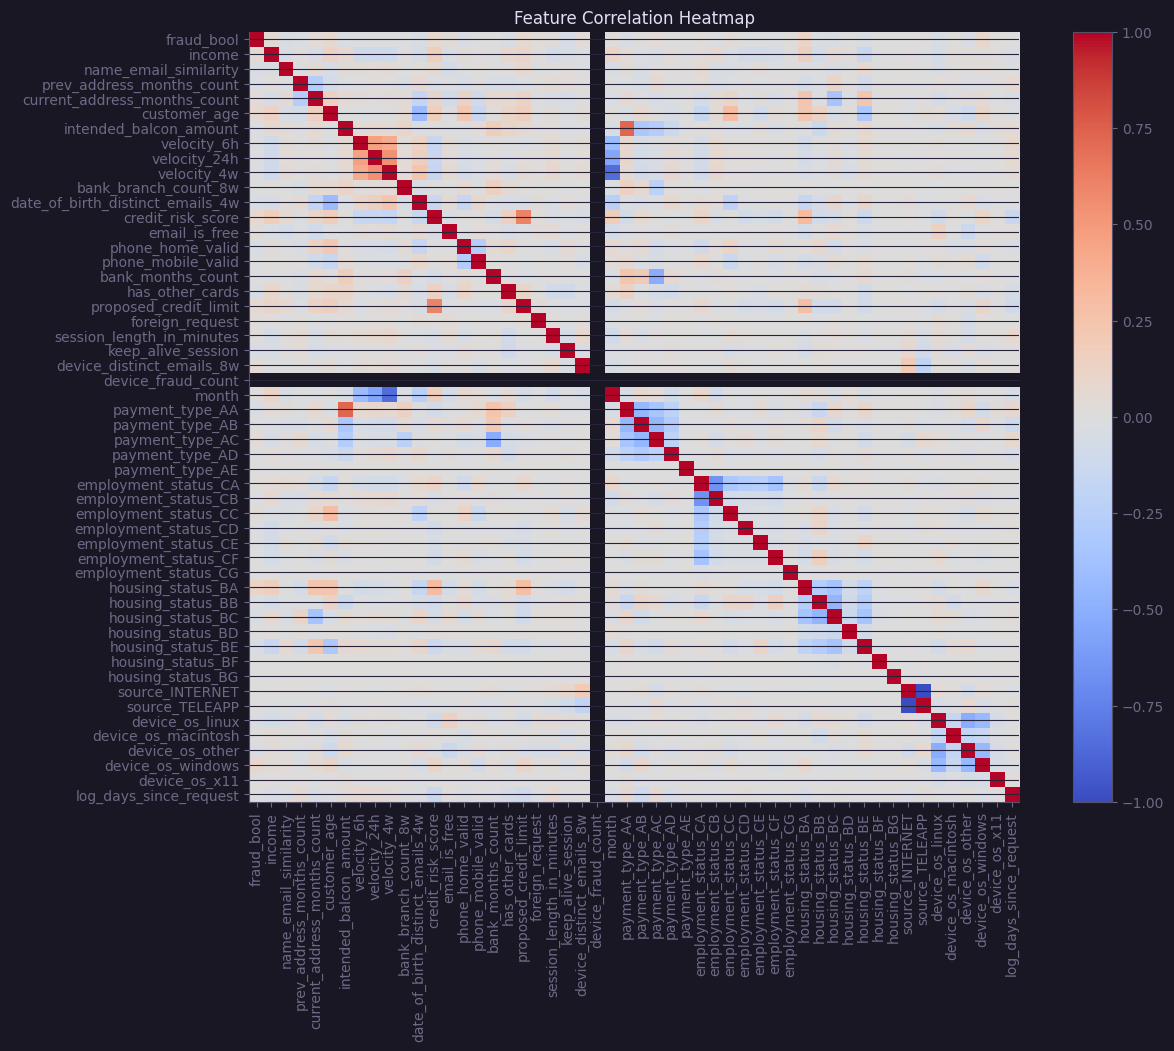

In [18]:
# Calculate the correlation matrix
correlation_matrix = cleaning_data.corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(14, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns),), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns),), correlation_matrix.columns)
plt.title('Feature Correlation Heatmap')
plt.show()


There are varying levels of correlation in the dataset. To quickly identify which are too heavily correlated, the matrix can be flattend to leave feature pairs and correlation value and sorted by value

In [19]:
# Reference column adding to enable the flattening
correlation_matrix['ref'] = correlation_matrix.index

In [20]:
# melt function flattens and values of 1 (the same variable correlation) excluded and sorted
flat_correlation_matrix = correlation_matrix.melt(id_vars='ref')
flat_correlation_matrix[
    (flat_correlation_matrix['value'] != 1) &
    (flat_correlation_matrix['value'] > 0.65)]

,ref,variable,value
337,payment_type_AA,intended_balcon_amount,0.72
1306,intended_balcon_amount,payment_type_AA,0.72


This leaves just one correlation pair of payment_type_AA and intended_balcon_amount. Inspecting the data, this correlation seems to come from when payment_type_AA is 0 the intended_balcon_amount is negative and vis versa.

To redunce the dependancy and limit overfitting, payment_type_AA is removed.

In [21]:
cleaning_data.drop(columns = 'payment_type_AA', inplace= True)

### 4.Feature selection

Using every feature within a model leads to an overfitted and inflexible model. It is therefor advantageous to identify the most impactful feature that contribute to predicting fraud, and remove the least useful ones.

#### Mutual Information Feature Selection Method
Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection.

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(cleaning_data.drop('fraud_bool', axis=1), cleaning_data['fraud_bool'], test_size=0.3, random_state=0)

In [24]:
X_train.head(5)

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,log_days_since_request
823666,0.70,0.79,-1,27,50,-1.16,5228.25,3716.58,4267.52,1,4,136,1,0,1,-1,0,200.00,0,8.31,1,1,0,5,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,-2.47
70066,0.80,0.81,38,12,40,11.70,4162.55,3448.22,3131.93,0,3,99,1,0,1,10,0,200.00,0,2.12,1,1,0,7,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,-2.54
591943,0.90,0.08,-1,204,60,-1.23,3849.85,4268.70,4376.80,10,1,156,0,1,1,28,1,500.00,0,1.98,0,1,0,6,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,-1.31
578645,0.80,0.48,-1,30,50,-1.23,1799.05,2767.62,4352.93,1,5,108,0,0,1,-1,0,200.00,0,13.26,0,1,0,6,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,-1.83
675461,0.70,0.05,-1,10,20,-1.19,7478.36,4528.15,6861.05,33,6,89,1,0,1,25,0,200.00,0,13.36,1,1,0,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,-1.79


In [25]:
raw_data['foreign_request'].describe

<bound method NDFrame.describe of 0         0
1         0
2         0
3         0
4         0
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Name: foreign_request, Length: 1000000, dtype: int64>

In [26]:
from sklearn.feature_selection import mutual_info_classif

# Determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([2.52570322e-02, 1.07113990e-03, 3.43543102e-03, 2.52057466e-03,
       3.81858312e-02, 6.34664407e-04, 1.33158252e-04, 4.55187400e-04,
       3.09725750e-04, 9.83888118e-04, 9.68417818e-03, 3.41137647e-03,
       1.11332911e-01, 7.65935720e-02, 1.25030882e-01, 1.00577429e-02,
       2.39114806e-02, 3.81394706e-02, 6.27577244e-04, 2.83899959e-04,
       1.22200088e-01, 1.49542738e-01, 0.00000000e+00, 1.86031126e-02,
       6.10453995e-02, 2.88820764e-02, 6.50736661e-03, 1.17524568e-04,
       1.40238859e-01, 9.07550554e-03, 1.31791362e-03, 8.33346573e-04,
       5.48433853e-04, 1.89693042e-03, 0.00000000e+00, 1.71706106e-02,
       3.19450229e-02, 6.28158190e-02, 6.10471984e-04, 1.39725895e-02,
       2.10163781e-05, 2.48127670e-05, 1.49838305e-01, 4.58262063e-05,
       5.13303064e-02, 2.73691590e-03, 5.36187869e-02, 3.35130744e-02,
       0.00000000e+00, 5.26531824e-04])

In [27]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info_sort = mutual_info.sort_values(ascending = False)
mutual_info_sort.head(15)

source_INTERNET             0.15
device_distinct_emails_8w   0.15
employment_status_CA        0.14
phone_mobile_valid          0.13
keep_alive_session          0.12
email_is_free               0.11
phone_home_valid            0.08
housing_status_BC           0.06
payment_type_AB             0.06
device_os_other             0.05
device_os_linux             0.05
customer_age                0.04
proposed_credit_limit       0.04
device_os_windows           0.03
housing_status_BB           0.03
dtype: float64

<Axes: >

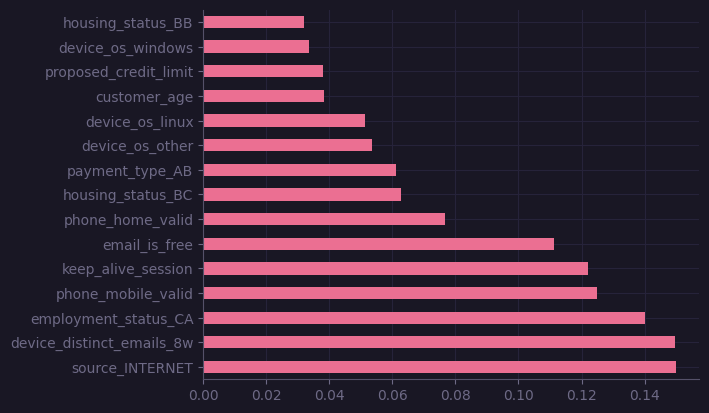

In [345]:
top_info_features = mutual_info_sort.index[0:15]
mutual_info_sort[top_info_features].plot(kind = 'barh')

#### Top Correlation Method

Interesting to see that an alternative method of looking at highest correlation provides a vastly different list of features. Mutual information method will be used primarily and will compare the reuslts to correlation method as part of the analysis

In [333]:
corr = cleaning_data.corr().round(1)

# Find features with strong correlation with target
target_corr = corr['fraud_bool'].abs().sort_values(ascending=False)
strong_corr_features = target_corr.index[1:16] 

print('Top 10 features with highest correlation with target:')
for feature in strong_corr_features:
    print(f"{feature}: {target_corr[feature]}")

Top 10 features with highest correlation with target:
device_os_windows: 0.1
customer_age: 0.1
keep_alive_session: 0.1
proposed_credit_limit: 0.1
credit_risk_score: 0.1
housing_status_BA: 0.1
housing_status_BC: 0.0
employment_status_CB: 0.0
employment_status_CC: 0.0
employment_status_CD: 0.0
employment_status_CE: 0.0
employment_status_CF: 0.0
employment_status_CG: 0.0
housing_status_BB: 0.0
housing_status_BE: 0.0


## 5. Sampling correction

Seen below, the number of fraud instances compared to non-fraud is extremely small. This is common among many different Machine Learning problems including Fraud Detection, Loan Defaulting Predictions and Insurance Claim Predictions. 

This in called Imbalanced Classification, where the dataset (and expected outcomes) are vastly disproportionate. Regular Machine Learning models struggle with this as they are designed for datasets with more balanced outcomes.

There are a number of ways to combat this:
- Gathering more data
- Differing sampling techniques
- Changing models
- Generating synthetic data

For this problem synthetic data will be generated to provide a data set that has more fraud outcomes. A risk of this is the assumption on the generated data posseing the same trends and nuances as the original data. This can be addressed in the evaluation of performance.

### Example: Customer Age

Seen below, the vast difference in the amount of instances in non-fraud to fraud. This makes is extremely hard for the algorithm to make correct predictions.

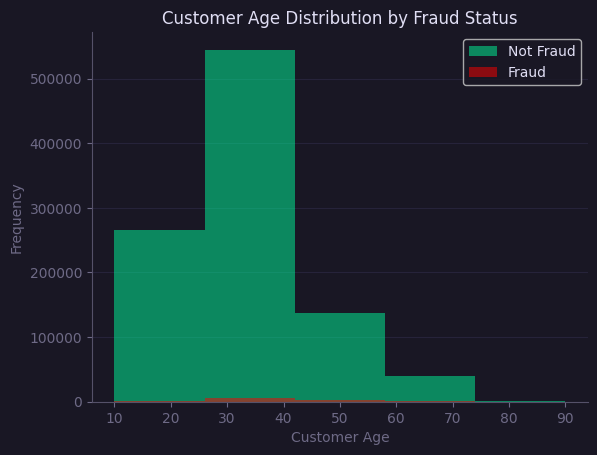

In [30]:
# Create a histogram plot
plt.hist([age for age, is_fraud in zip(cleaning_data['customer_age'], cleaning_data['fraud_bool']) if is_fraud == 0], 
         bins=5, alpha=0.5, label='Not Fraud', color='mediumspringgreen')
plt.hist([age for age, is_fraud in zip(cleaning_data['customer_age'], cleaning_data['fraud_bool']) if is_fraud == 1], 
         bins=5, alpha=0.5, label='Fraud', color='red')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution by Fraud Status')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Synthetic Minority Over-sampling Technique

As its name suggests, SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Distribution of label values before applying SMOTE:\n',pd.Series(y_train).value_counts())
print('Distribution of label values after applying SMOTE:\n',pd.Series(y_train_smote).value_counts())

Distribution of label values before applying SMOTE:
 fraud_bool
0    692249
1      7751
Name: count, dtype: int64
Distribution of label values after applying SMOTE:
 fraud_bool
0    692249
1    692249
Name: count, dtype: int64


After applying SMOTE the dataset now has a 50-50 split of fraud and non-fraud

In [32]:
dataset_SMOTE = X_train_smote
dataset_SMOTE['fraud_bool'] = y_train_smote

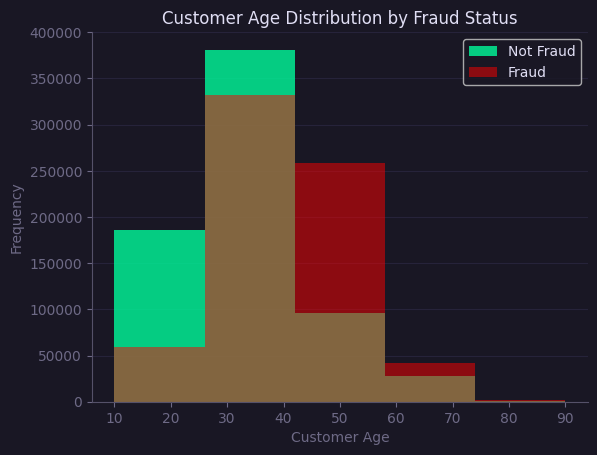

In [33]:
# Create a histogram plot
plt.hist([age for age, is_fraud in zip(dataset_SMOTE['customer_age'], dataset_SMOTE['fraud_bool']) if is_fraud == 0], 
         bins=5, alpha=0.8, label='Not Fraud', color='mediumspringgreen')
plt.hist([age for age, is_fraud in zip(dataset_SMOTE['customer_age'], dataset_SMOTE['fraud_bool']) if is_fraud == 1], 
         bins=5, alpha=0.5, label='Fraud', color='red')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution by Fraud Status')

# Add a legend
plt.legend()

# Show the plot
plt.show()

The histogram shows the 50-50 distribution of fraud and non-fraud using the generated data

In [34]:
smote_counts = pd.DataFrame(dataset_SMOTE['fraud_bool'].value_counts()).reset_index()

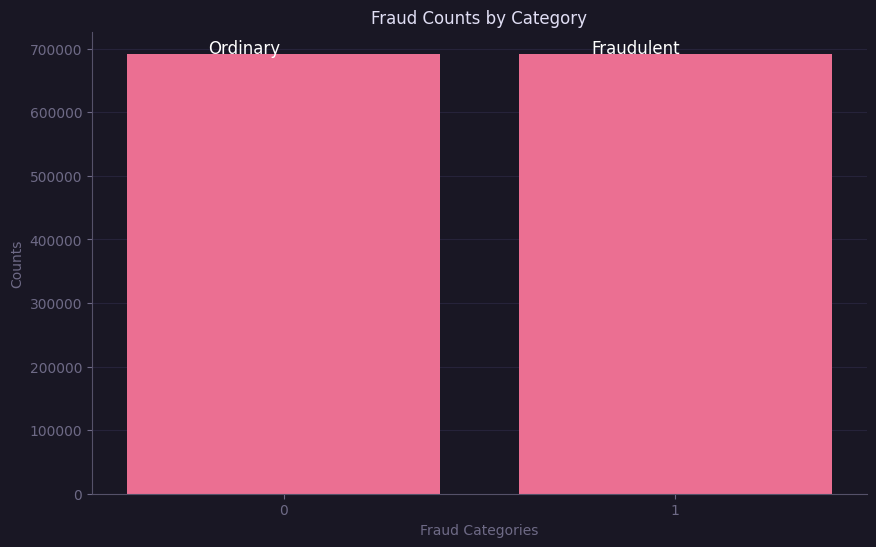

In [35]:
plt.style.use('rose-pine')

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(smote_counts['fraud_bool'],smote_counts['count'])
plt.xlabel('Fraud Categories')
plt.ylabel('Counts')
plt.title('Fraud Counts by Category')

labels = ['Ordinary', 'Fraudulent']

# Add custom labels to the bars
for bar, label in zip(bars, labels):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, label, ha='center', color='white', fontsize=12)

# Customize the x-axis tick labels
plt.xticks([0, 1], ['0', '1'])

# Show the chart
plt.show()

C:\Users\e014694\AppData\Local\Temp\ipykernel_13468\947906394.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleaning_data[c][cleaning_data.fraud_bool == 1], bins=50)
C:\Users\e014694\AppData\Local\Temp\ipykernel_13468\947906394.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleaning

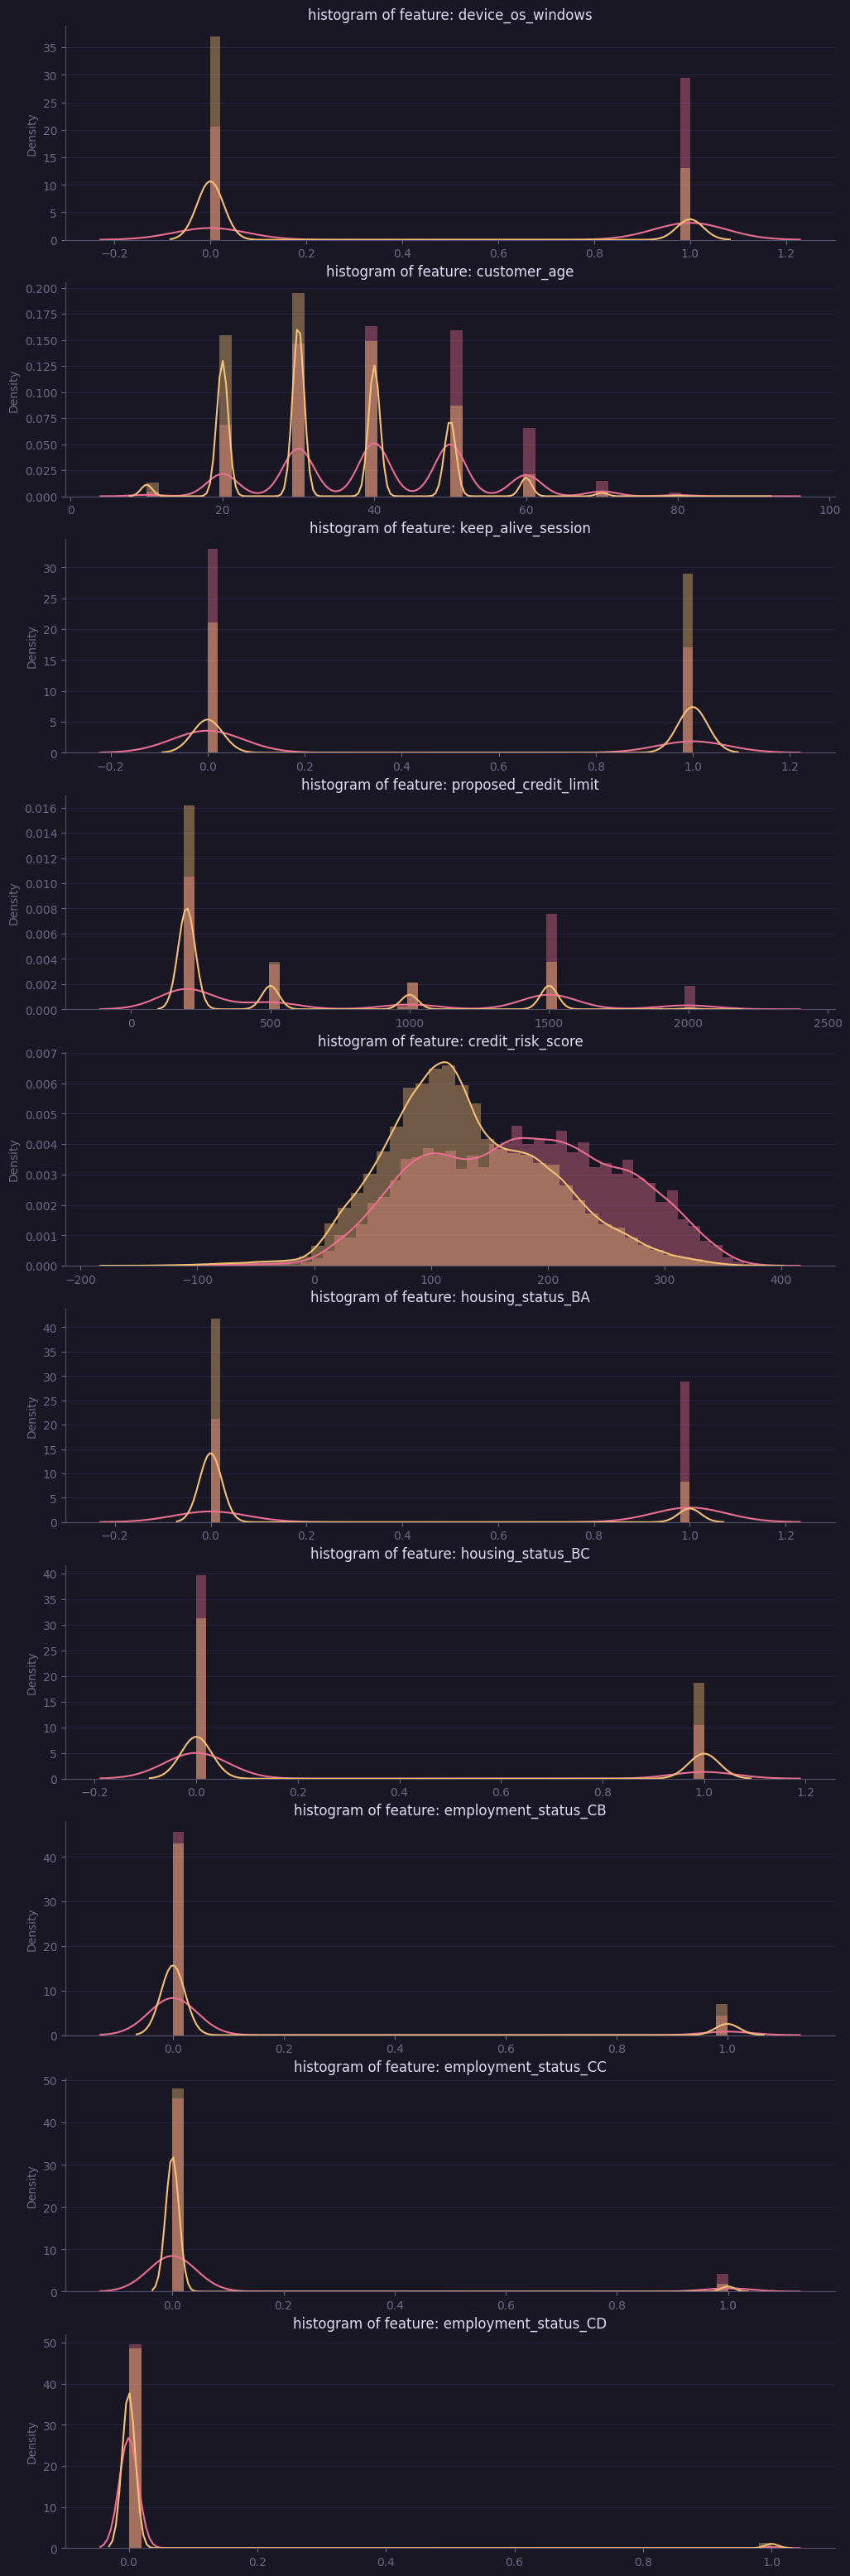

In [141]:
from matplotlib import gridspec
import seaborn as sns
# distribution of anomalous features


plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, c in enumerate(cleaning_data[strong_corr_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(cleaning_data[c][cleaning_data.fraud_bool == 1], bins=50)
    sns.distplot(cleaning_data[c][cleaning_data.fraud_bool == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(c))
plt.show()

# 5. Model Build

The aim is to assess a number of varying model and evaluate differences and performance.

Models:
- Linear Regression
- K Nearest Neighbour (KNN)
- Random Forest
- Gradient Boosted ....GBA
- Artifical Neural Network (ANN)

In [147]:
cleaning_data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,log_days_since_request
0,1,0.90,0.17,-1,88,50,-1.33,10650.77,3134.32,3863.65,1,6,185,0,1,0,24,0,500.00,0,3.89,0,1,0,7,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,-1.68
1,1,0.90,0.30,-1,144,50,-0.82,534.05,2670.92,3124.30,718,3,259,1,0,0,15,0,1500.00,0,31.80,0,1,0,7,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,-2.27
2,1,0.90,0.04,-1,132,40,-0.76,4048.53,2893.62,3159.59,1,14,177,1,0,1,-1,0,200.00,0,4.73,0,1,0,7,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,0.49
3,1,0.90,0.16,-1,22,50,-1.21,3457.06,4054.91,3022.26,1921,6,110,1,0,1,31,1,200.00,0,2.05,0,1,0,7,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,-1.72
4,1,0.90,0.60,-1,218,50,-0.77,5020.34,2728.24,3087.67,1990,2,295,1,1,0,31,0,1500.00,0,3.78,1,1,0,7,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,-2.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.60,0.19,-1,104,40,-1.04,7905.71,8341.47,4972.64,1,8,75,1,1,1,25,0,200.00,0,8.51,1,1,0,4,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,-1.51
999996,0,0.80,0.32,148,9,50,-1.41,5391.47,4955.17,5022.73,0,2,154,1,1,1,-1,0,200.00,0,8.97,0,1,0,4,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,0.21
999997,0,0.80,0.88,-1,30,20,34.69,8063.10,5670.65,4377.20,2023,6,64,0,0,1,11,0,200.00,0,8.20,0,1,0,4,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,-1.73
999998,0,0.90,0.76,-1,189,20,94.66,8092.64,3982.58,4394.80,1678,6,163,0,1,0,28,0,500.00,0,4.34,1,1,0,4,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,-1.81


-----------------------------------------

In [347]:
X_train, X_test, y_train, y_test = train_test_split(cleaning_data.drop('fraud_bool', axis=1),
                                                    cleaning_data['fraud_bool'],
                                                    test_size=0.2,
                                                    random_state=0)

In [348]:
# Data Prep
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[top_info_features])
X_test = scaler.fit_transform(X_test[top_info_features])


In [349]:
# from imblearn.under_sampling import RandomUnderSampler
# undersampler = RandomUnderSampler(sampling_strategy=0.02, random_state=0)

# X_undersampled, y_understampled = undersampler.fit_resample(X_train, y_train)

# print('Distribution of label values before applying SMOTE:\n',pd.Series(y_train).value_counts())
# print('Distribution of label values after applying SMOTE:\n',pd.Series(y_understampled).value_counts())

In [350]:
smote = SMOTE(sampling_strategy= 0.9,random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Distribution of label values before applying SMOTE:\n',pd.Series(y_train).value_counts())
print('Distribution of label values after applying SMOTE:\n',pd.Series(y_train_smote).value_counts())

Distribution of label values before applying SMOTE:
 fraud_bool
0    791142
1      8858
Name: count, dtype: int64
Distribution of label values after applying SMOTE:
 fraud_bool
0    791142
1    712027
Name: count, dtype: int64


#### 5.1 Linear Regression

In [351]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [352]:
lr.fit(X_train_smote, y_train_smote)

LogisticRegression()

In [353]:
lr_pred = lr.predict(X_test)

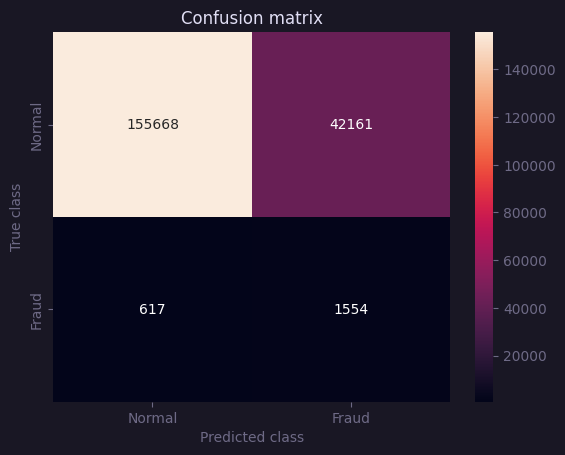

In [354]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, auc

LABELS = ['Normal', 'Fraud']

lr_matrix = confusion_matrix(y_test,lr_pred)
sns.heatmap(lr_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [355]:
accuracy_score(y_test,lr_pred)

0.78611

In [356]:
print (classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88    197829
           1       0.04      0.72      0.07      2171

    accuracy                           0.79    200000
   macro avg       0.52      0.75      0.47    200000
weighted avg       0.99      0.79      0.87    200000



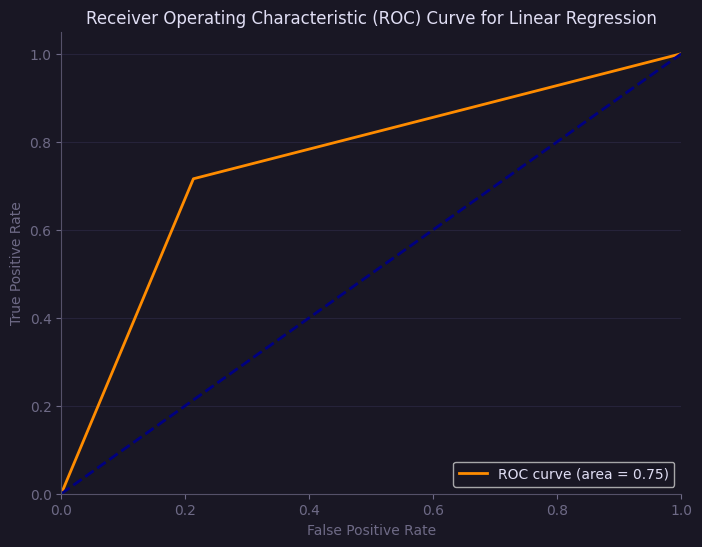

In [357]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lr_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression')
plt.legend(loc='lower right')
plt.show()

## 5.2 Random Forest

In [222]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(max_samples=len(X_train_smote),random_state=1)
rfc.fit(X_train_smote,y_train_smote)
# scores_pred = rfc.decision_function(X_train_smote_c)

KeyboardInterrupt: 

In [ ]:
rf_pred = rfc.predict(X_test)

In [196]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, auc, precision_score, recall_score, f1_score, matthews_corrcoef

import seaborn as sns

              precision    recall  f1-score   support

           0       0.99      0.39      0.56    296722
           1       0.01      0.71      0.02      3278

    accuracy                           0.40    300000
   macro avg       0.50      0.55      0.29    300000
weighted avg       0.98      0.40      0.56    300000



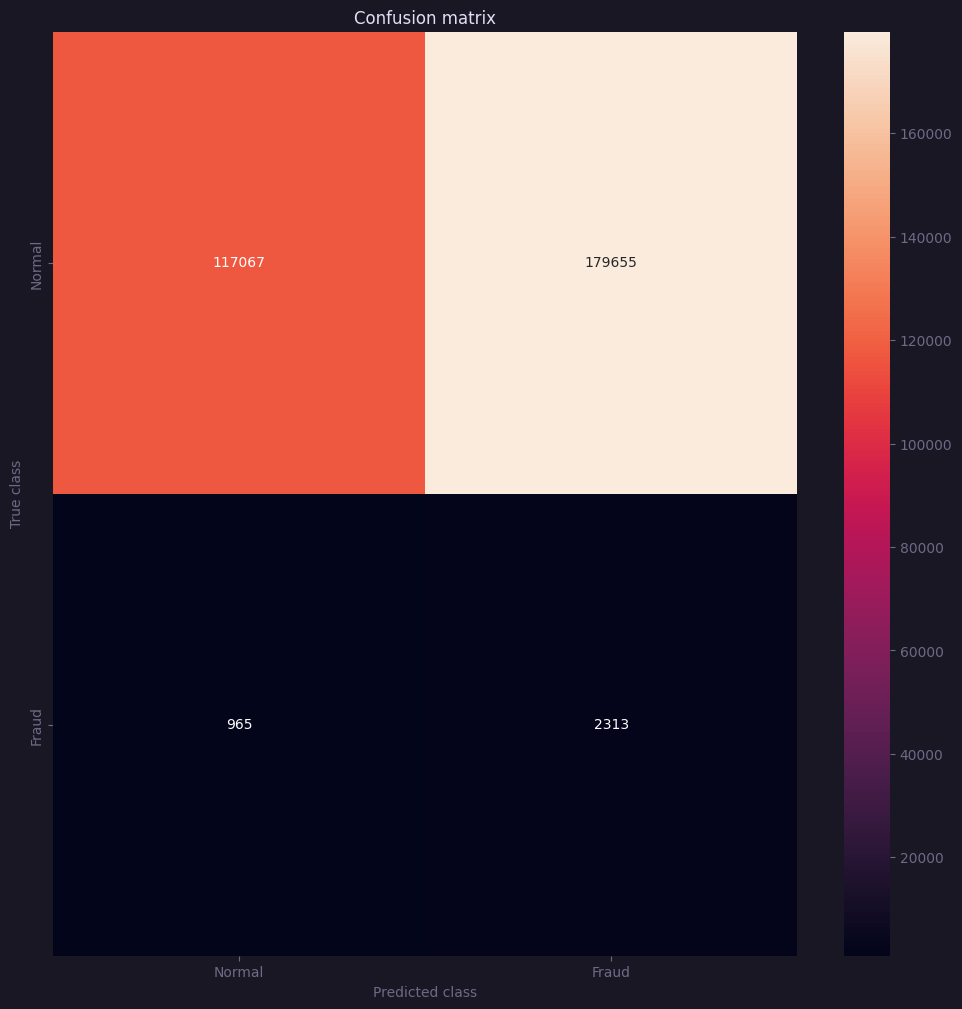

In [197]:
print(classification_report(y_test,rf_pred))

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

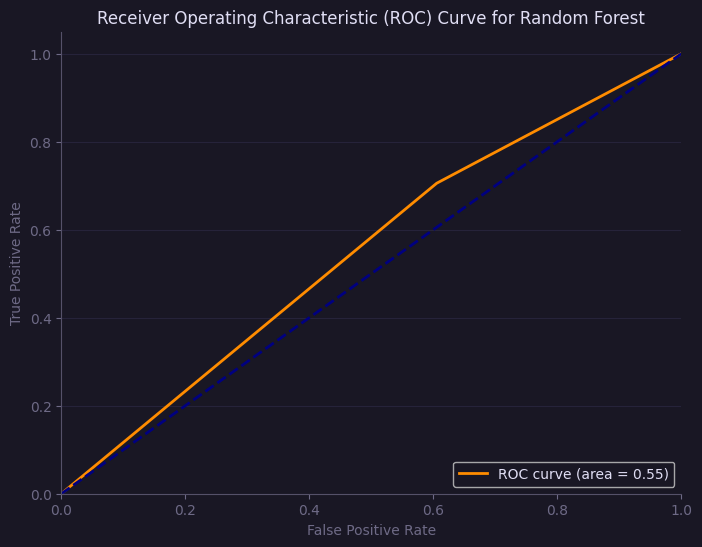

In [207]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

--------------------------------

In [223]:
X_train, X_test, y_train, y_test = train_test_split(cleaning_data.drop('fraud_bool', axis=1),
                                                    cleaning_data['fraud_bool'],
                                                    test_size=0.3,
                                                    random_state=0,
                                                    shuffle = True)

In [224]:
X_scaled = scaler.fit_transform(X_train)

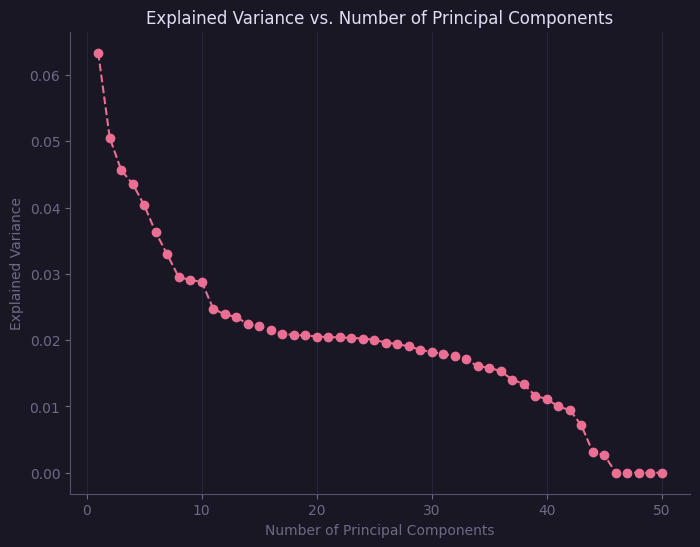

Cumulative Explained Variance:
PC1: 0.06
PC2: 0.11
PC3: 0.16
PC4: 0.20
PC5: 0.24
PC6: 0.28
PC7: 0.31
PC8: 0.34
PC9: 0.37
PC10: 0.40
PC11: 0.42
PC12: 0.45
PC13: 0.47
PC14: 0.49
PC15: 0.52
PC16: 0.54
PC17: 0.56
PC18: 0.58
PC19: 0.60
PC20: 0.62
PC21: 0.64
PC22: 0.66
PC23: 0.68
PC24: 0.70
PC25: 0.72
PC26: 0.74
PC27: 0.76
PC28: 0.78
PC29: 0.80
PC30: 0.82
PC31: 0.84
PC32: 0.85
PC33: 0.87
PC34: 0.89
PC35: 0.90
PC36: 0.92
PC37: 0.93
PC38: 0.94
PC39: 0.96
PC40: 0.97
PC41: 0.98
PC42: 0.99
PC43: 0.99
PC44: 1.00
PC45: 1.00
PC46: 1.00
PC47: 1.00
PC48: 1.00
PC49: 1.00
PC50: 1.00


In [226]:
from sklearn.decomposition import PCA

pca=PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i}' for i in range(1, X_pca.shape[1] + 1)])

# Create a scree plot to visualize the explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

# Print the cumulative explained variance
print("Cumulative Explained Variance:")
for i, variance in enumerate(cumulative_variance, 1):
    print(f'PC{i}: {variance:.2f}')

In [235]:
# Define the number of principal components you want to keep
n_components = 20

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])

In [251]:
X_train, X_test, y_train, y_test = train_test_split(cleaning_data.drop('fraud_bool', axis=1),
                                                    cleaning_data['fraud_bool'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle = True)

In [252]:
# Apply SMOTE
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Distribution of label values before applying SMOTE:\n',pd.Series(y_train).value_counts())
print('Distribution of label values after applying SMOTE:\n',pd.Series(y_train_smote).value_counts())

Distribution of label values before applying SMOTE:
 fraud_bool
0    791142
1      8858
Name: count, dtype: int64
Distribution of label values after applying SMOTE:
 fraud_bool
0    791142
1    791142
Name: count, dtype: int64


In [253]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [258]:
# Define the number of principal components to retain
n_components = 10

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [270]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca, y_train_smote)

LogisticRegression()

In [271]:
y_pred = lr.predict(X_test_pca)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    197829
           1       0.06      0.54      0.10      2171

    accuracy                           0.89    200000
   macro avg       0.52      0.72      0.52    200000
weighted avg       0.98      0.89      0.93    200000



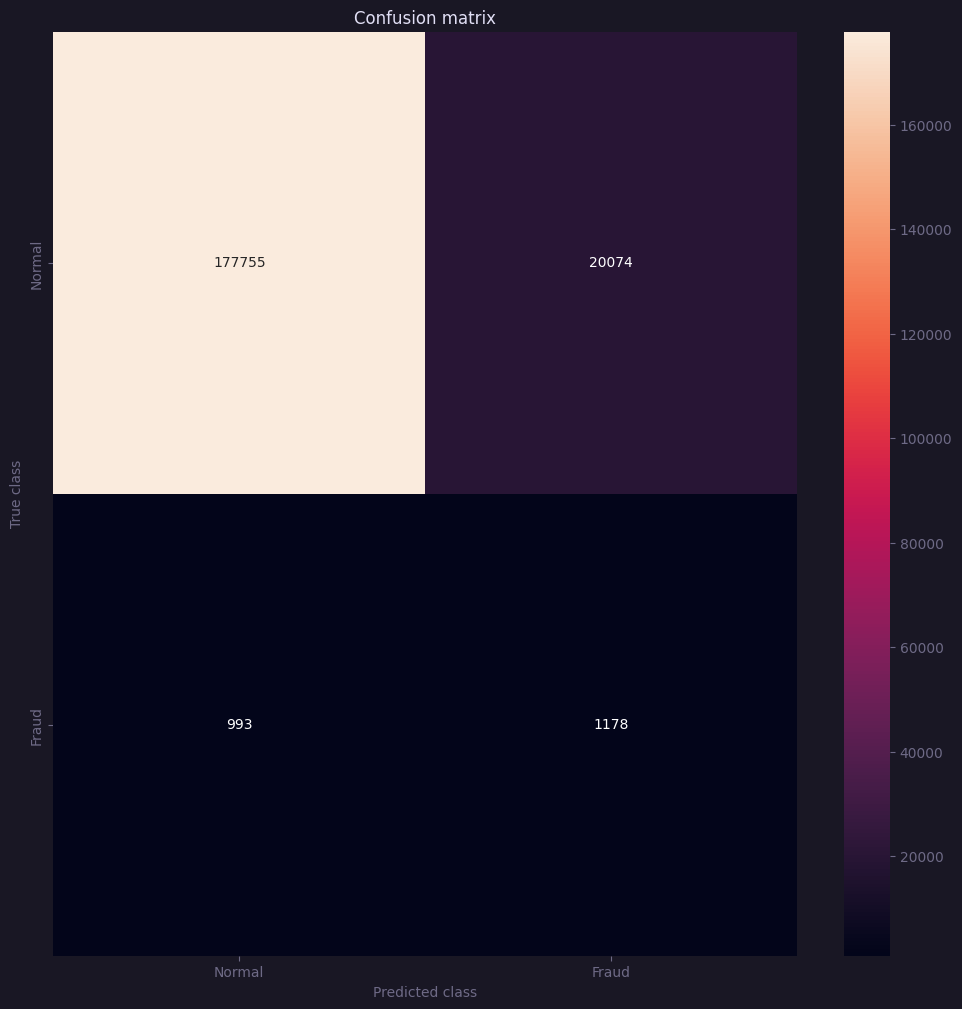

In [272]:
print(classification_report(y_test,y_pred))

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

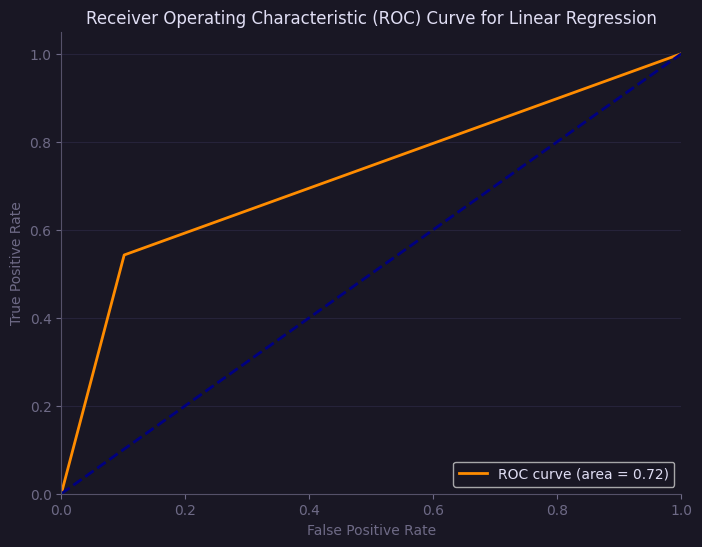

In [273]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression')
plt.legend(loc='lower right')
plt.show()